Preprocessing func and mfcc extraction

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
sample time: 16.00 ms


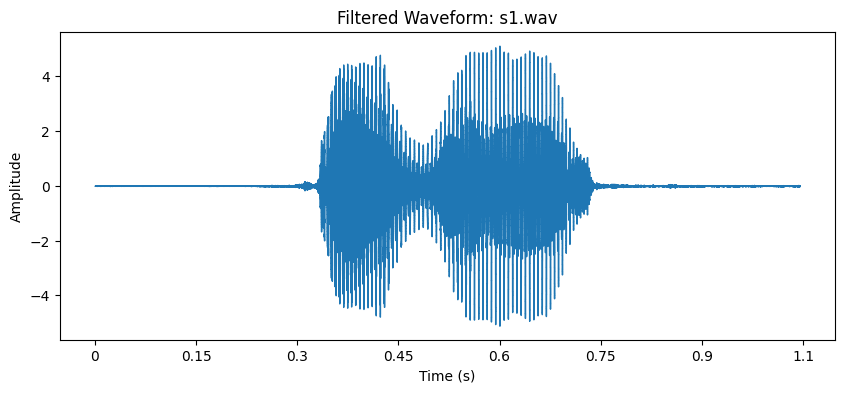

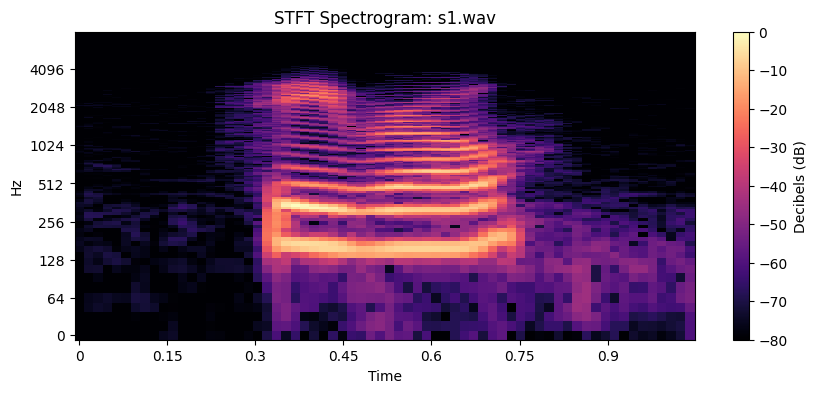

/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


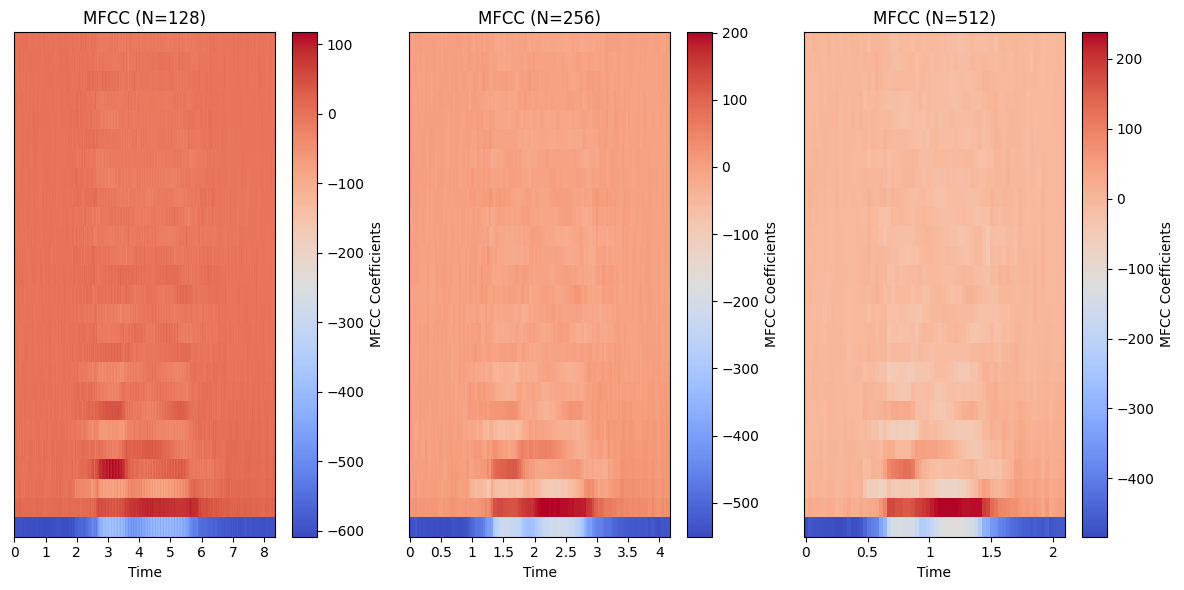

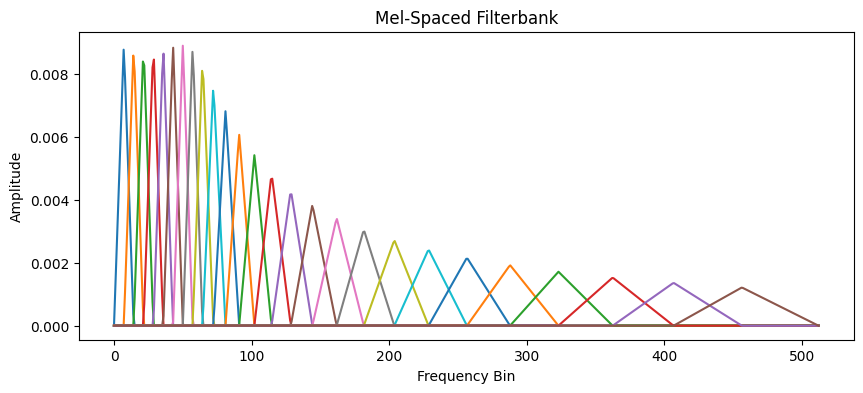

sample time: 16.00 ms


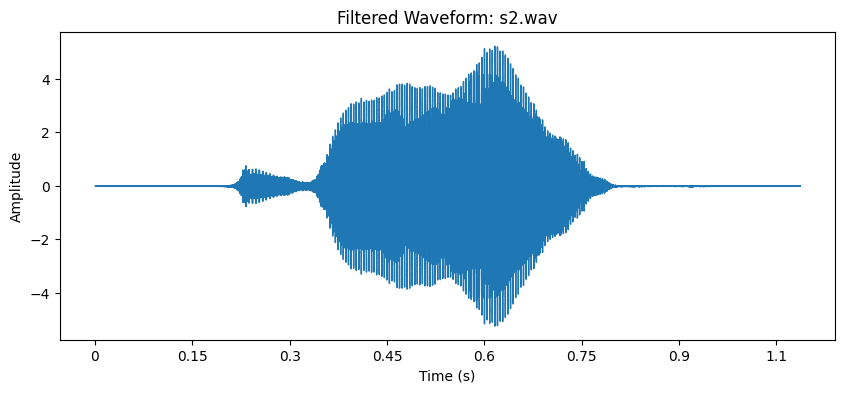

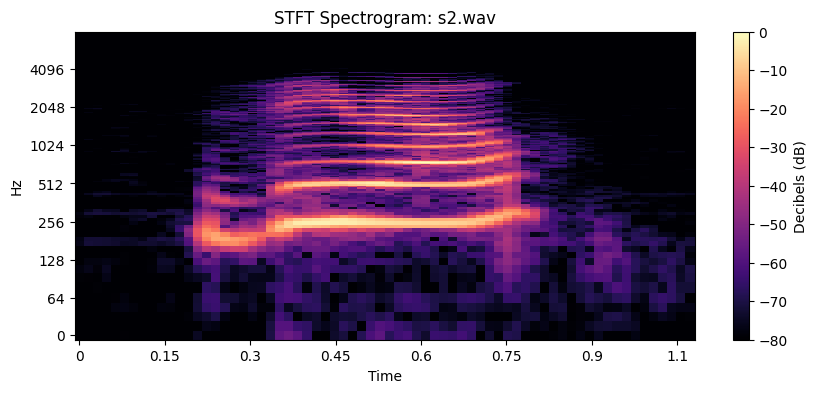

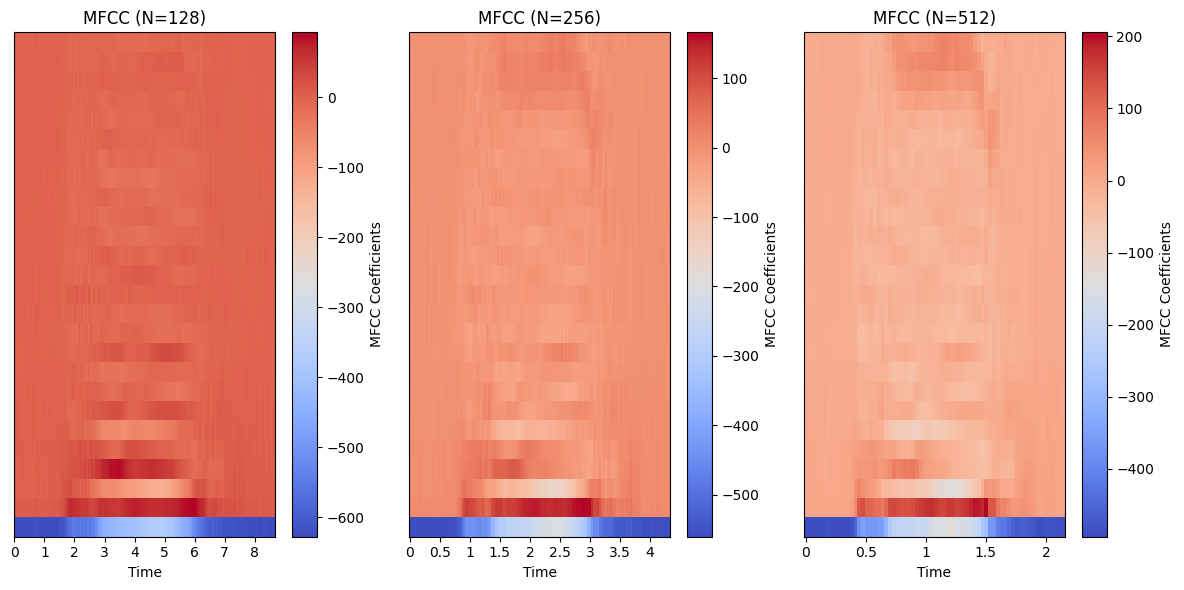

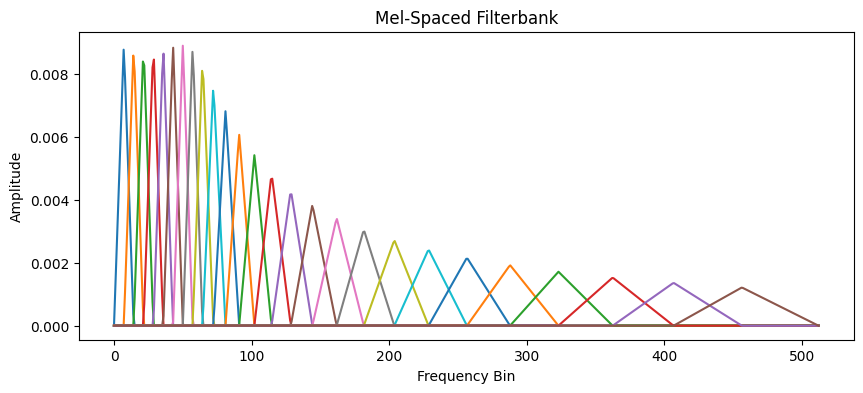

sample time: 16.00 ms


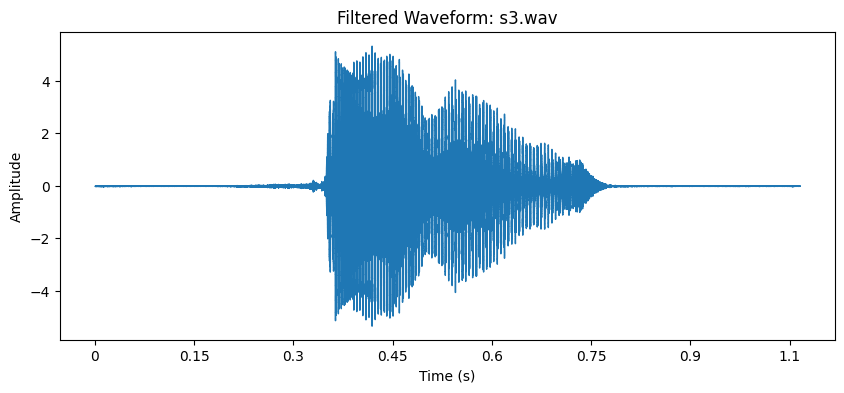

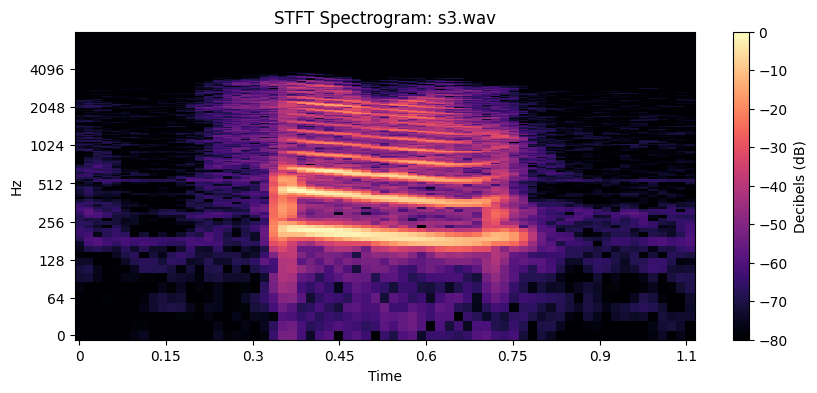

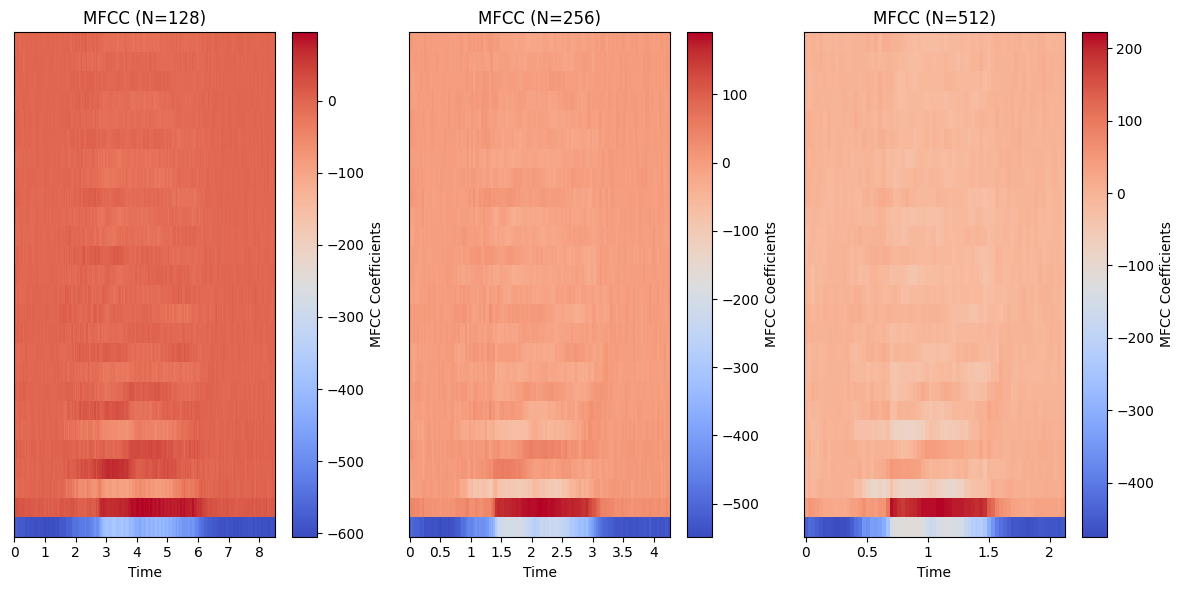

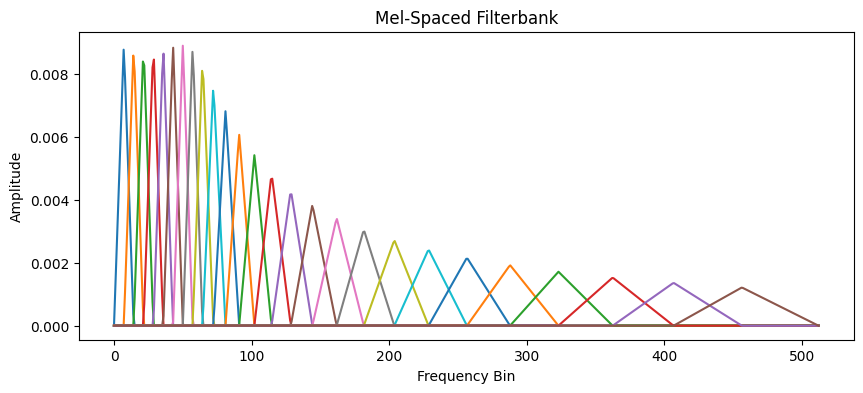

sample time: 16.00 ms


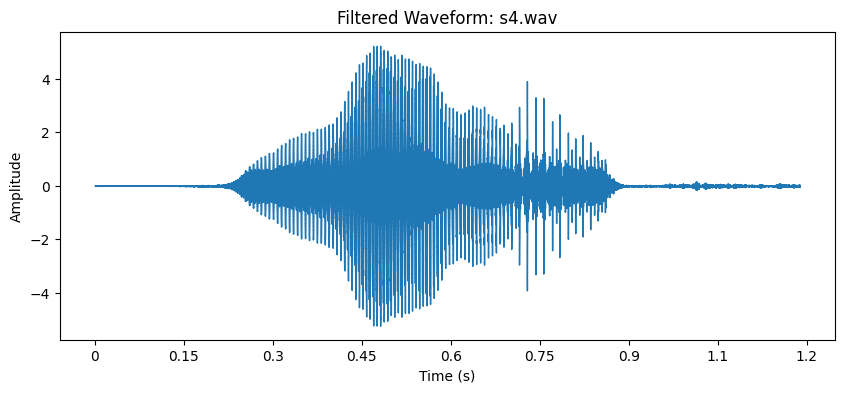

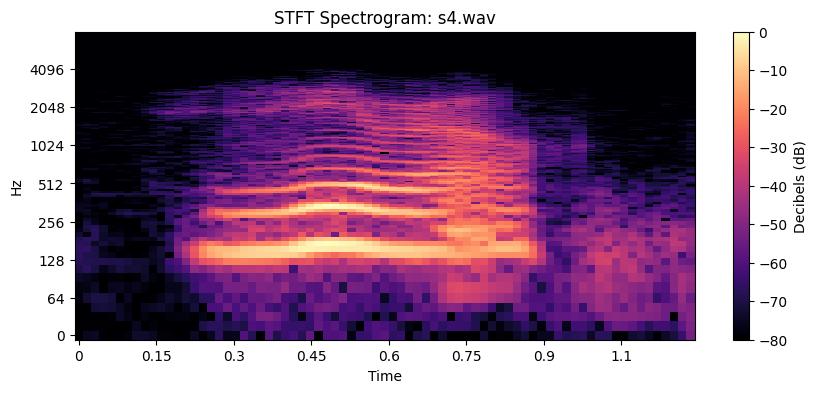

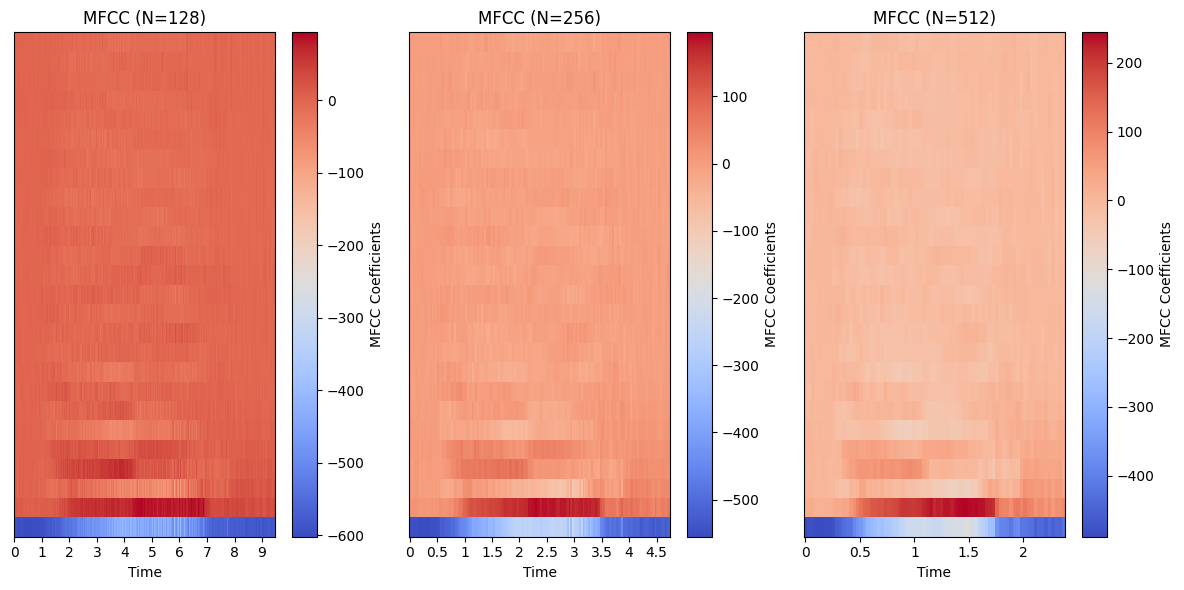

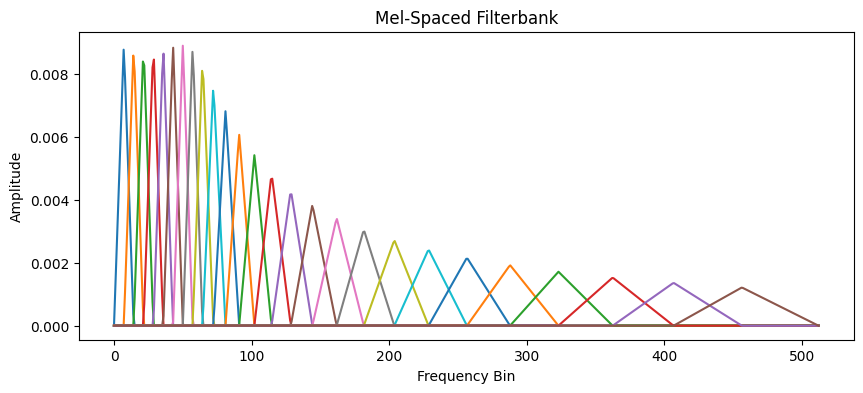

sample time: 16.00 ms


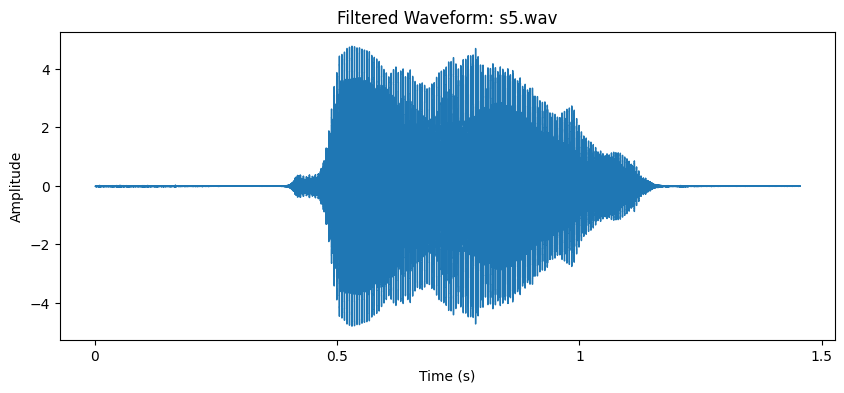

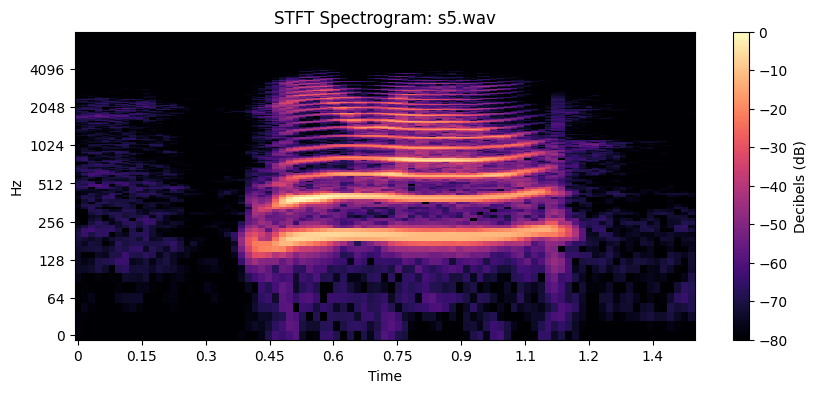

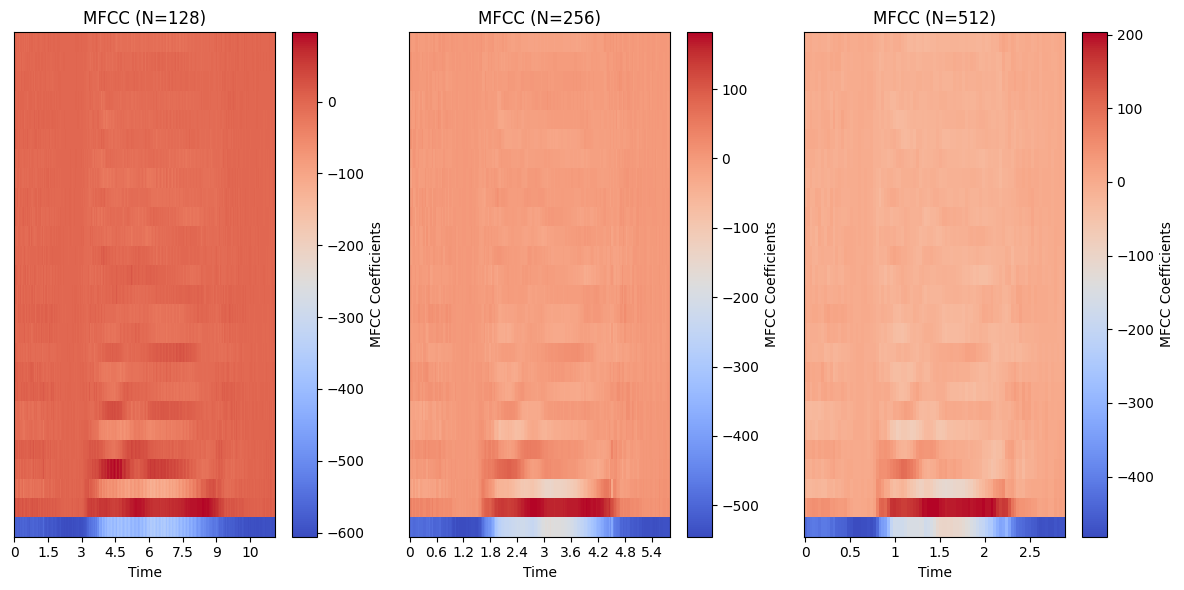

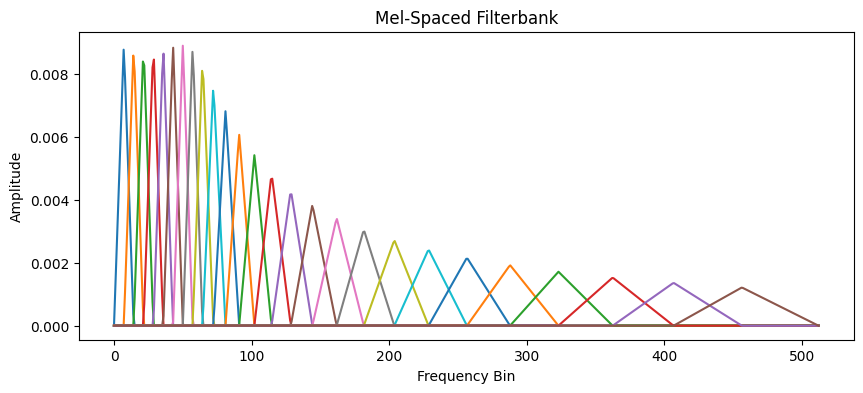

sample time: 16.00 ms


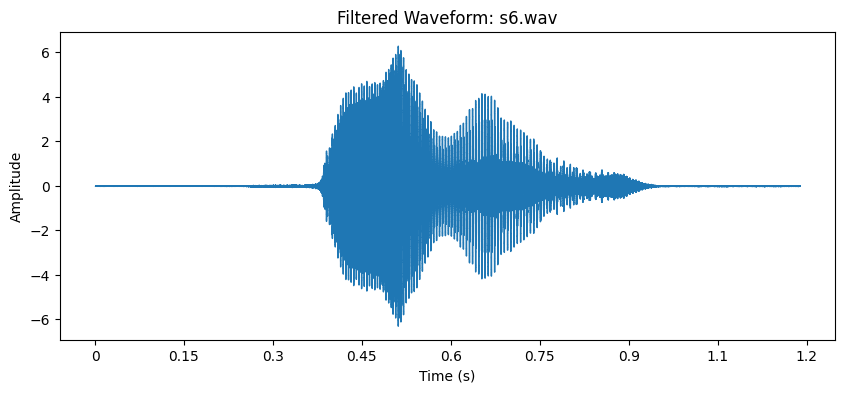

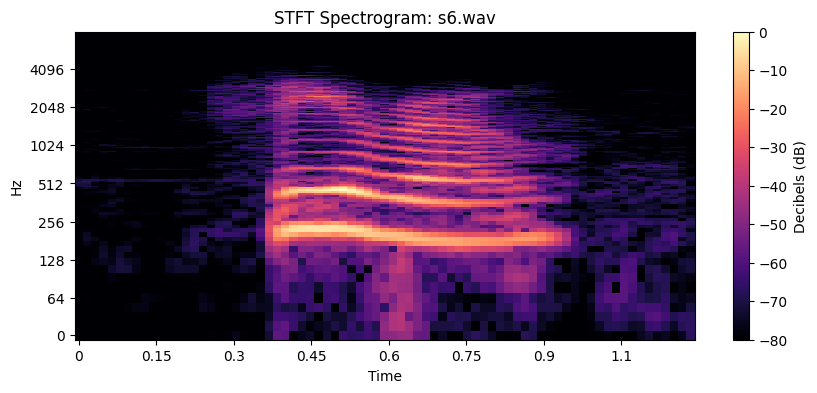

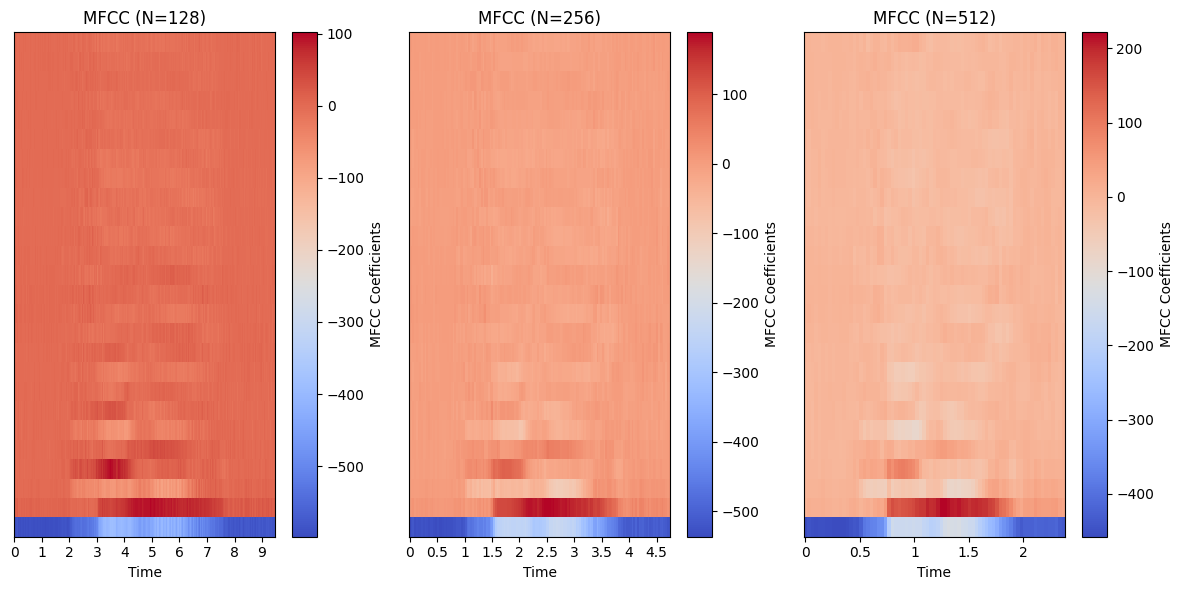

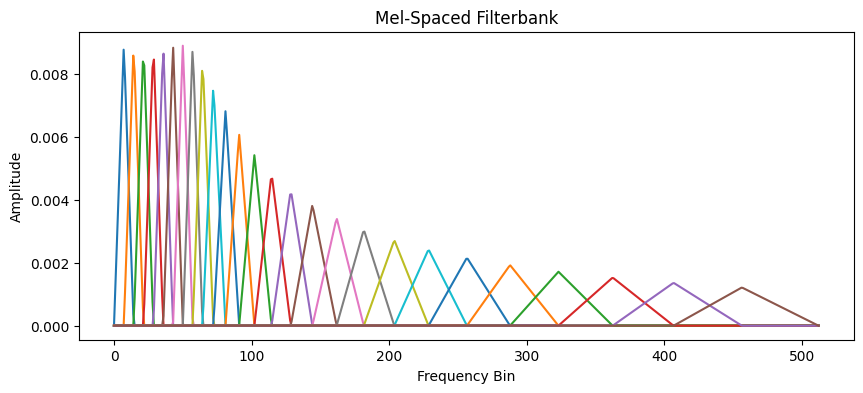

sample time: 16.00 ms


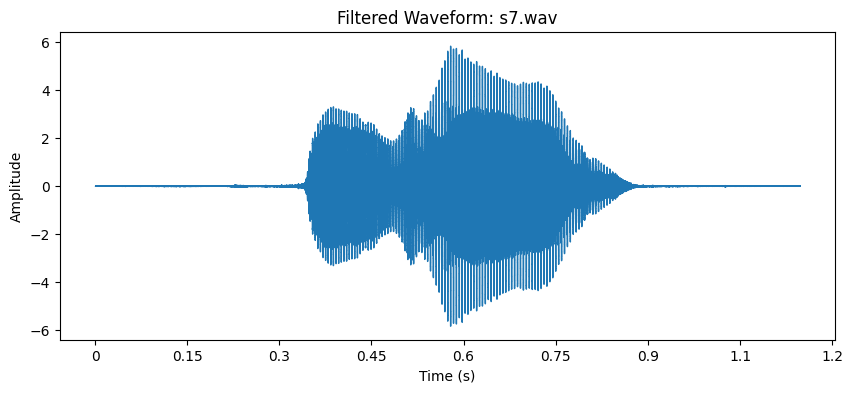

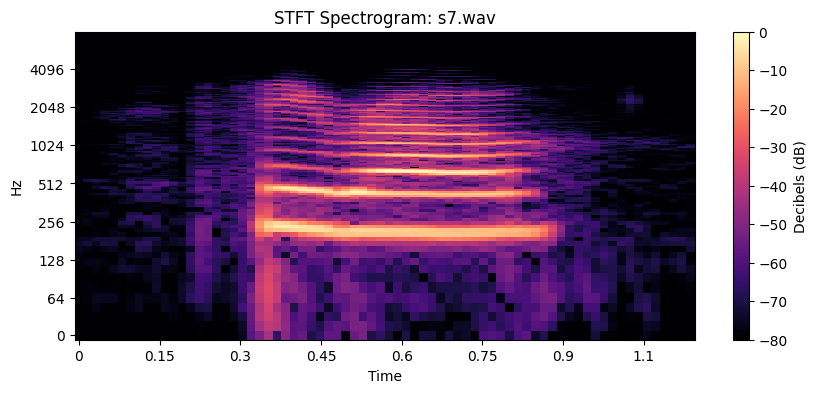

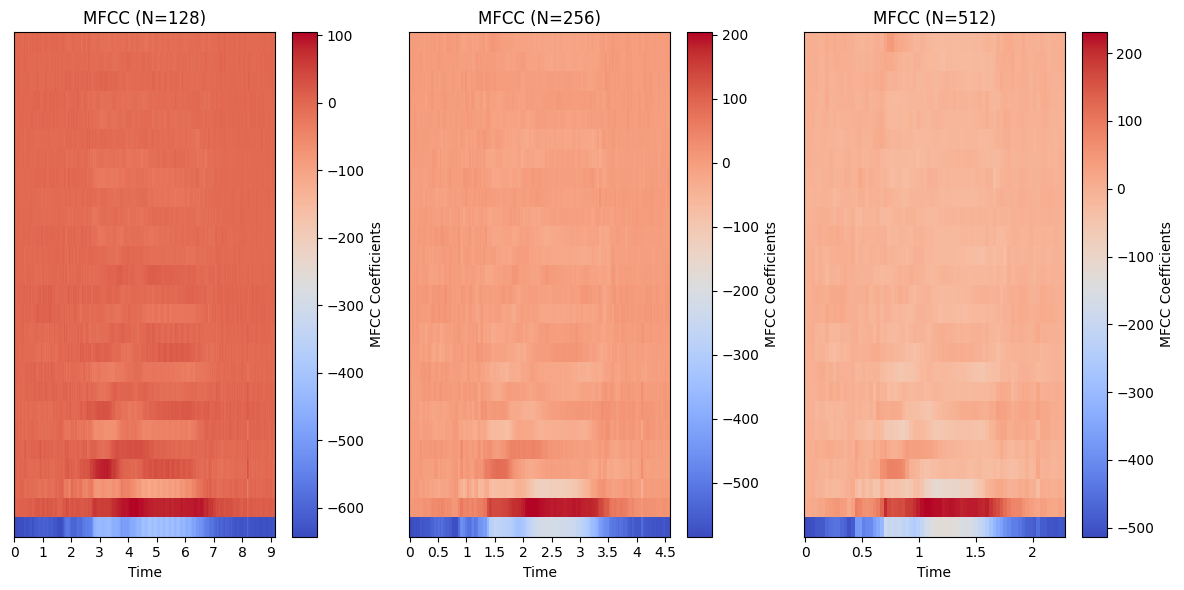

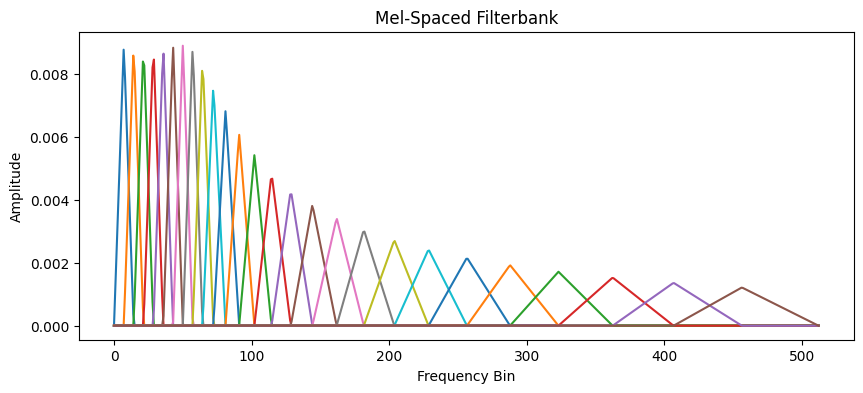

sample time: 16.00 ms


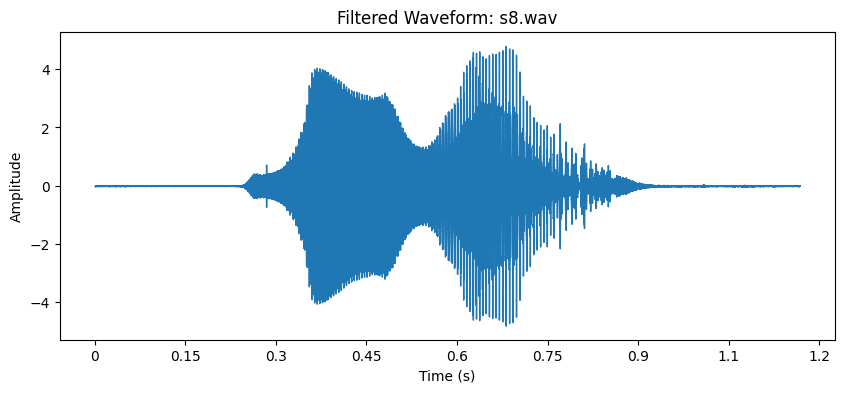

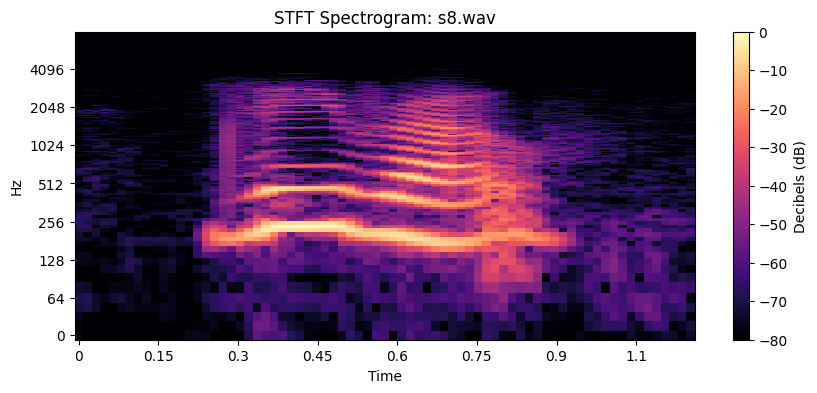

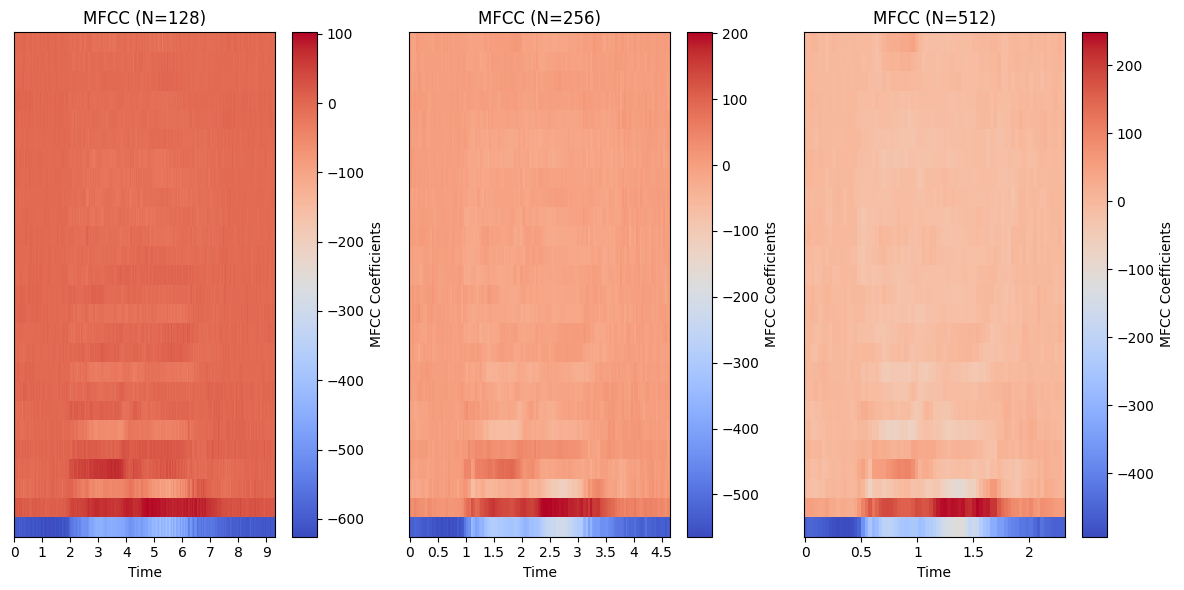

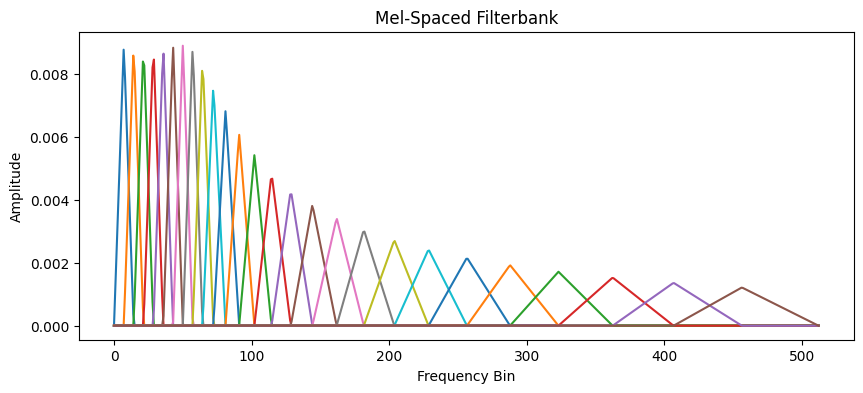

sample time: 16.00 ms


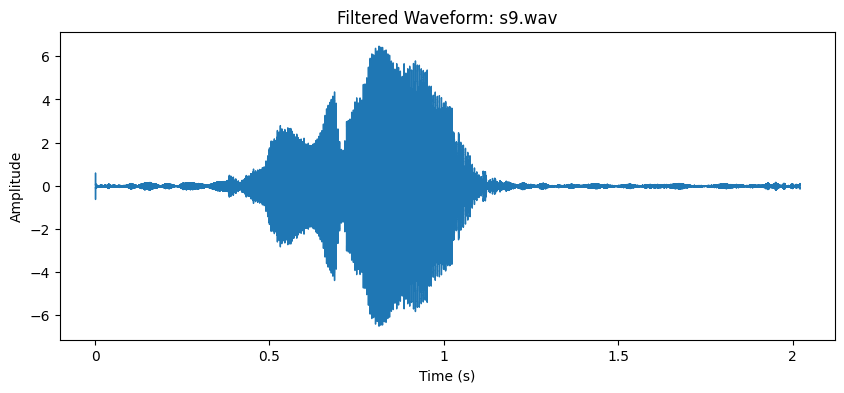

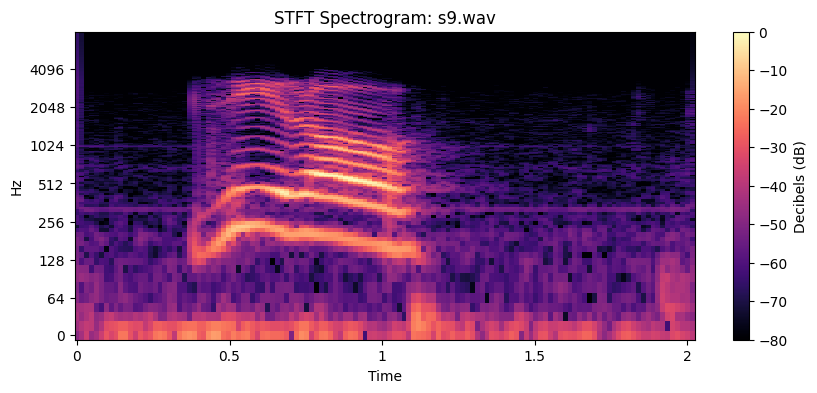

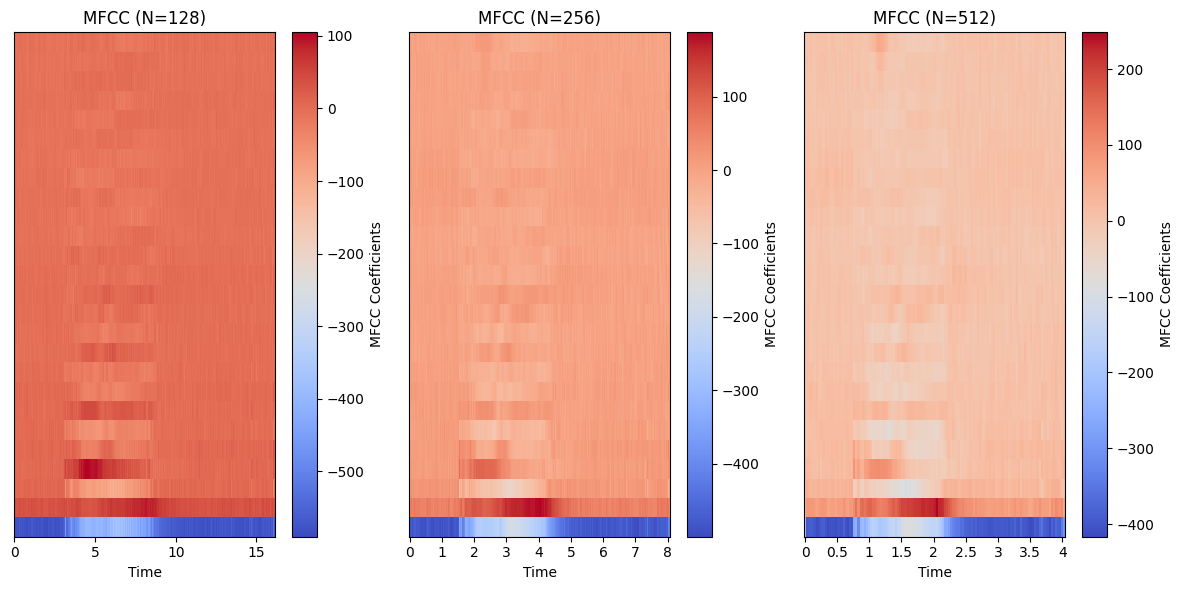

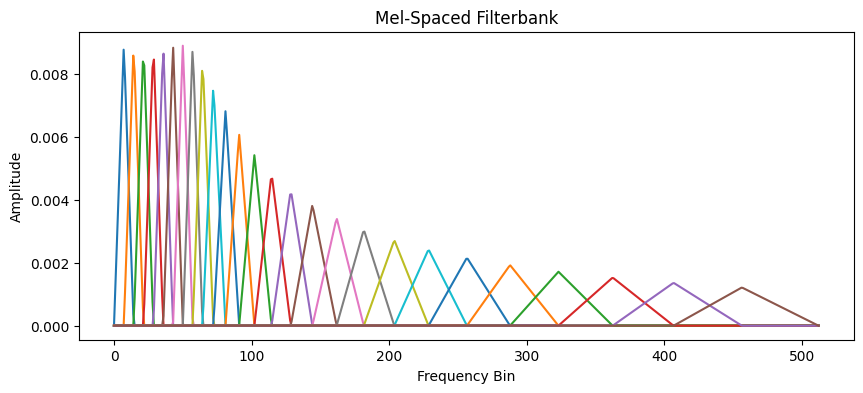

sample time: 16.00 ms


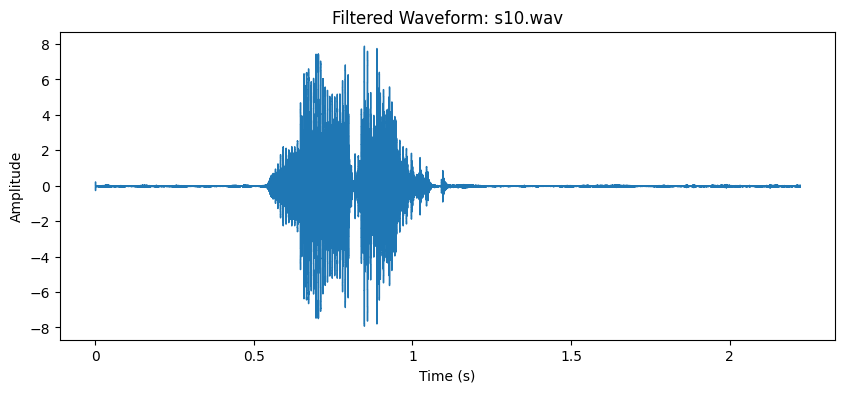

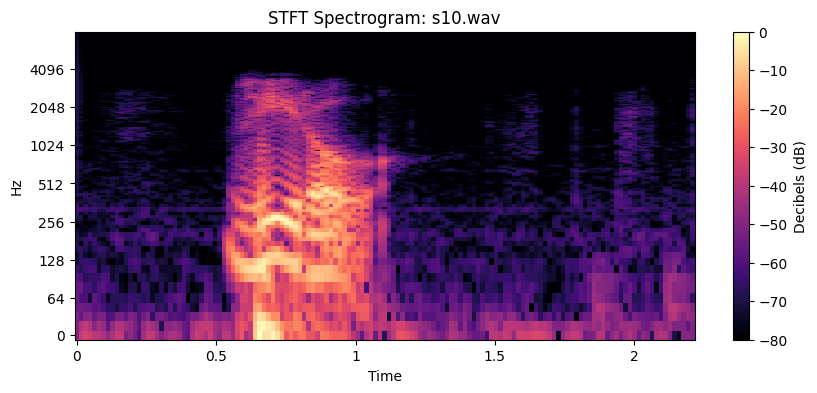

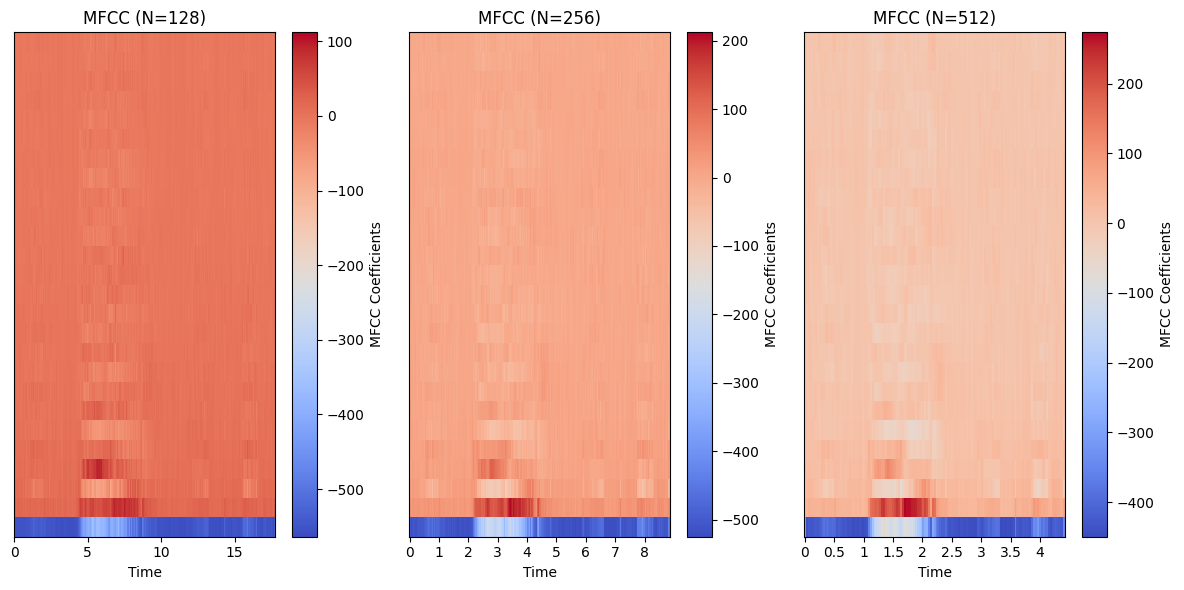

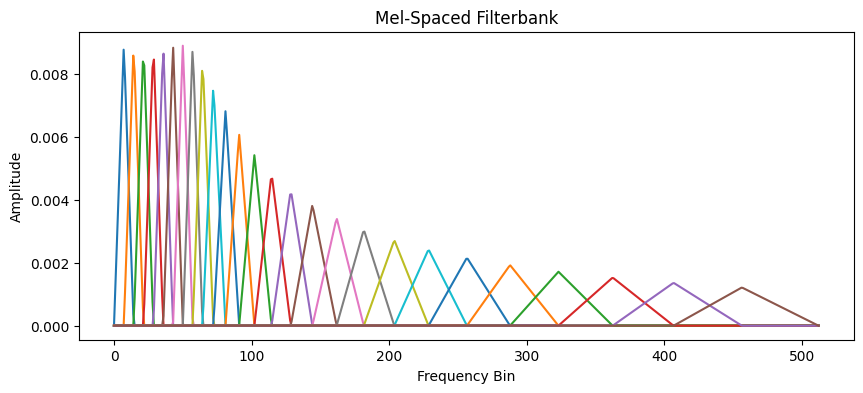

sample time: 16.00 ms


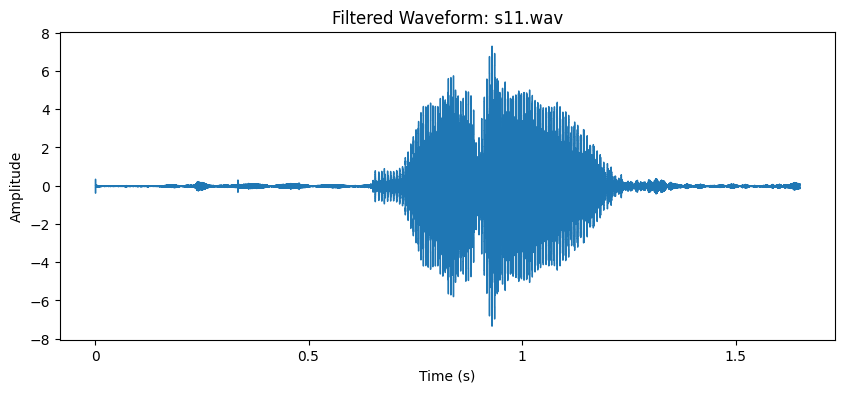

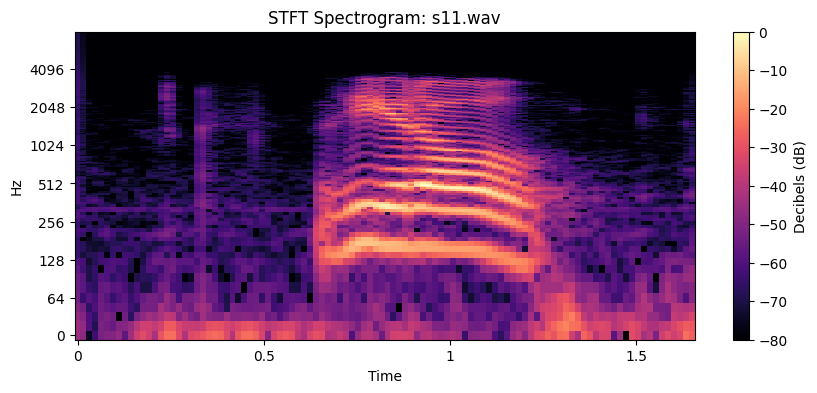

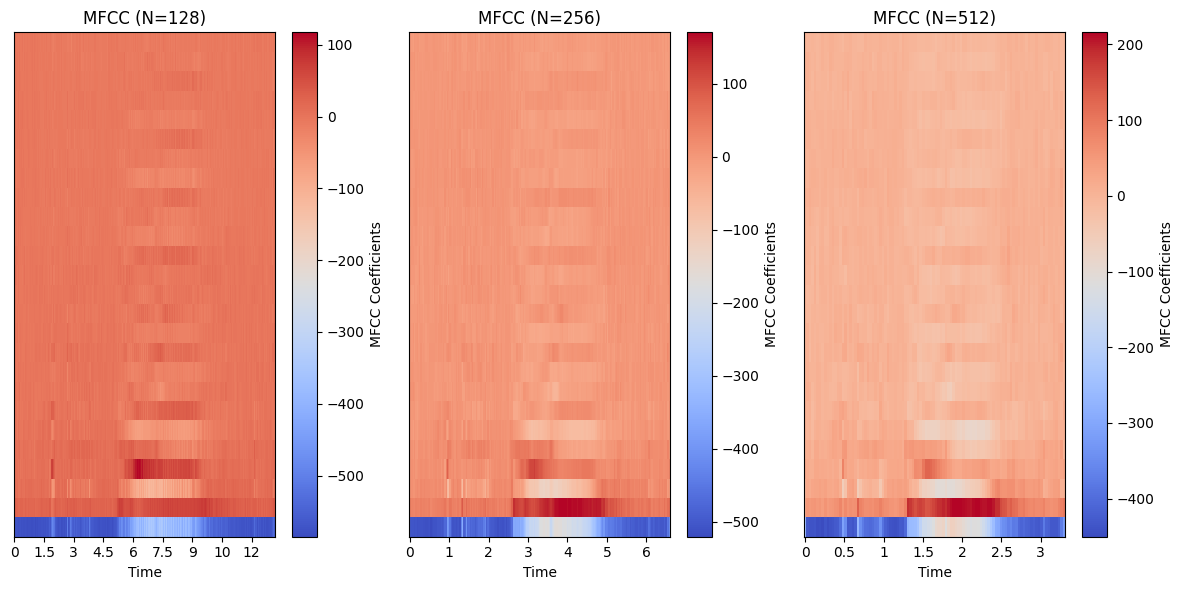

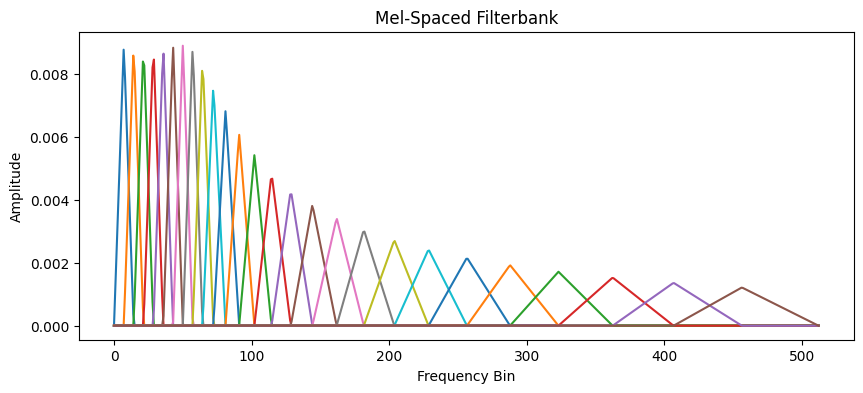

In [372]:
from google.colab import drive
drive.mount('/content/drive')
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

# Path link
DRIVE_PATH = "/content/drive/MyDrive/GivenSpeech_Data/Training_Data"
audio_files = ["s1.wav", "s2.wav", "s3.wav","s4.wav","s5.wav","s6.wav","s7.wav","s8.wav","s9.wav","s10.wav","s11.wav"]

mfcc_features = {}
labels = {}

def load_audio(file_name, base_path, sr=16000): # load audio from selected path
    file_path = os.path.join(base_path, file_name)
    if not os.path.exists(file_path):
        print(f"file{file_path}non-exist！")
        return None, None
    signal, sample_rate = librosa.load(file_path, sr=sr)
    return signal, sample_rate

def normalize_audio(signal):
    return (signal - np.mean(signal)) / np.std(signal) # np.ndarray

def lowpass_filter(signal, sr, cutoff=3000, order=5):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = scipy.signal.filtfilt(b, a, signal)
    return filtered_signal # np.ndarray

def compute_sample_time(sr, N=256):
    time_ms = (N / sr) * 1000
    print(f"sample time: {time_ms:.2f} ms")

def compute_mfcc(signal, sr, n_mfcc=26, n_fft=1024, hop_length=256):
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfccs # np.ndarray

def plot_waveform(signal, sr, title="Waveform"):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(signal, sr=sr)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()


def plot_stft(signal, sr, n_fft=1024, hop_length=256, title="STFT Spectrogram"):
    D = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(label="Decibels (dB)")
    plt.title(title)
    plt.show()

# Different window sizes mfcc
def compare_mfcc(signal, sr):
    n_fft_values = [128, 256, 512]
    plt.figure(figsize=(12, 6))
    for i, n_fft in enumerate(n_fft_values):
        mfccs = compute_mfcc(signal, sr, n_mfcc=26, n_fft=n_fft, hop_length=n_fft//2)
        plt.subplot(1, 3, i+1)
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
        plt.colorbar(label="MFCC Coefficients")
        plt.title(f"MFCC (N={n_fft})")
    plt.tight_layout()
    plt.show()

def plot_mel_filterbank(sr=16000, n_fft=1024, n_mels=26):
    mel_filters = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    plt.figure(figsize=(10, 4))
    for i in range(mel_filters.shape[0]):
        plt.plot(mel_filters[i], label=f"Mel {i+1}")
    plt.title("Mel-Spaced Filterbank")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Amplitude")
    plt.show()

# Preprocess function
# Return value: filtered_signal and mfcc_matrix
def process_audio(file_name, base_path, speaker_id):
    signal, sr = load_audio(file_name=file_name, base_path=base_path)
    normalized_signal = normalize_audio(signal)
    filtered_signal = lowpass_filter(normalized_signal, sr)
    mfccs = compute_mfcc(filtered_signal, sr)

    compute_sample_time(sr)
    plot_waveform(filtered_signal, sr, title=f"Filtered Waveform: {file_name}")
    plot_stft(filtered_signal, sr, title=f"STFT Spectrogram: {file_name}")
    compare_mfcc(filtered_signal, sr)
    plot_mel_filterbank(sr, n_fft=1024, n_mels=26)

    # Assure PERSON in dictionary
    if speaker_id not in mfcc_features:
        mfcc_features[speaker_id] = []  # initialization
        labels[speaker_id] = []

    mfcc_features[speaker_id].append(mfccs.T)
    labels[speaker_id].append(np.full(mfccs.shape[1], speaker_id))
    return filtered_signal, mfccs


for i, file in enumerate(audio_files):
    speaker_id = i + 1  # speaker ID starts from 1
    filtered_signal, mfccs = process_audio(file, DRIVE_PATH, speaker_id)







> Vector Quantization, codebook



In [373]:
#print(len(labels))
#print(labels)
#print(len(mfcc_features))

In [374]:
from scipy.cluster.vq import kmeans, vq

def normalize_mfcc(mfcc_features):
    mfcc_features = np.vstack(mfcc_features)
    mean = np.mean(mfcc_features, axis=0)
    std = np.std(mfcc_features, axis=0)
    return (mfcc_features - mean) / std


def lbg_algorithm(features, num_clusters=16, epsilon=0.01):
    codebook, _ = kmeans(features, 1)
    while codebook.shape[0] < num_clusters:
        new_codebook = np.vstack([codebook * (1 + epsilon), codebook * (1 - epsilon)])
        new_codebook, _ = kmeans(features, new_codebook.shape[0])
        codebook = new_codebook
    return codebook

def train_vq_codebook_per_speaker(mfcc_features, num_clusters=16):
    speaker_codebooks = {}
    for speaker_id, features in mfcc_features.items():
        features = np.vstack(features)  # combine features of this guy
        codebook = lbg_algorithm(features, num_clusters)  # train with lbg
        speaker_codebooks[speaker_id] = codebook
    return speaker_codebooks

vq_codebooks = train_vq_codebook_per_speaker(mfcc_features, num_clusters=16)


visualize codebook

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

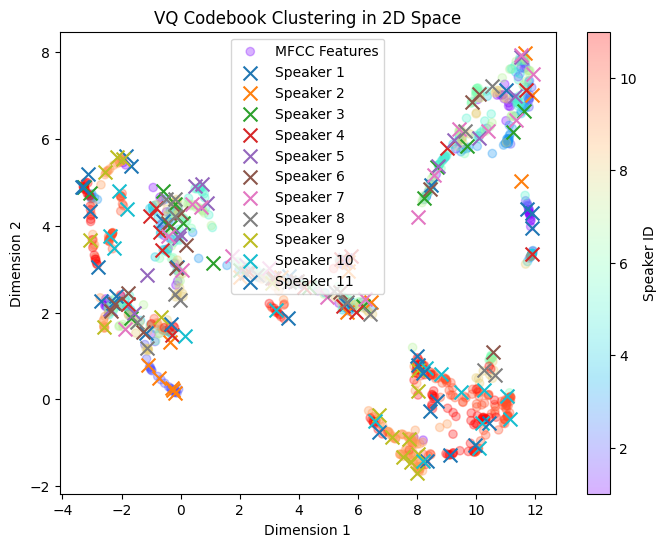

In [375]:
import umap

def plot_vq_codebook_umap(mfcc_features, labels, codebooks):
    all_mfcc_features = np.vstack([np.vstack(features) for features in mfcc_features.values()])
    all_labels = np.concatenate([np.concatenate(label) for label in labels.values()])
    reducer = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.05, metric='euclidean') #dimension reduce
    reduced_mfcc = reducer.fit_transform(all_mfcc_features)
    reduced_codebooks = {speaker: reducer.transform(codebooks[speaker]) for speaker in codebooks}

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_mfcc[:, 0], reduced_mfcc[:, 1], c=all_labels, cmap='rainbow', alpha=0.3, label="MFCC Features")
    # mark x on graph
    for speaker, reduced_codebook in reduced_codebooks.items():
        plt.scatter(reduced_codebook[:, 0], reduced_codebook[:, 1], marker='x', s=100, label=f"Speaker {speaker}")

    plt.colorbar(scatter, label="Speaker ID")
    plt.title("VQ Codebook Clustering in 2D Space")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.show()

plot_vq_codebook_umap(mfcc_features, labels, vq_codebooks)



Original Test data features extract

In [376]:

test_drive_path = "/content/drive/MyDrive/GivenSpeech_Data/Test_Data"
test_audio_files = ["s1.wav", "s2.wav", "s3.wav", "s4.wav", "s5.wav", "s6.wav", "s7.wav", "s8.wav"]
test_mfcc_features = []
test_labels = []

def process_test_audio(file_name):
    signal, sr = load_audio(file_name=file_name, base_path=test_drive_path)
    normalized_signal = normalize_audio(signal)
    filtered_signal = lowpass_filter(normalized_signal, sr)
    mfccs = compute_mfcc(filtered_signal, sr)
    return mfccs.T

# featuring testing set
for file in test_audio_files:
    mfcc_matrix = process_test_audio(file)
    test_mfcc_features.append(mfcc_matrix)


<ipython-input-372-38df9661874d>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sample_rate = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [377]:
# print(len(test_mfcc_features))

In [378]:
# print(len(mfcc_features))

Matching Speakers

In [379]:
from scipy.spatial.distance import cdist

def match_speaker(test_mfcc, codebook):
    distances = cdist(test_mfcc, codebook, metric='euclidean')  # distance to codebook
    avg_distance = np.mean(np.min(distances, axis=1))  # avg min dist
    return avg_distance

# Matching training and testing speakers
results = {}

for i, test_mfcc in enumerate(test_mfcc_features):
    min_dist = float('inf')
    best_speaker = None
    for speaker_id in range(1, len(audio_files) + 1):
        if speaker_id in vq_codebooks:
            dist = match_speaker(test_mfcc, vq_codebooks[speaker_id])  # return avg min dist
            if dist < min_dist:
                min_dist = dist
                best_speaker = speaker_id # matching best speaker id

    results[test_audio_files[i]] = best_speaker

for test_file, speaker in results.items():
    print(f"TEST file {test_file} might be SPEAKER id: {speaker}")



TEST file s1.wav might be SPEAKER id: 1
TEST file s2.wav might be SPEAKER id: 2
TEST file s3.wav might be SPEAKER id: 3
TEST file s4.wav might be SPEAKER id: 4
TEST file s5.wav might be SPEAKER id: 5
TEST file s6.wav might be SPEAKER id: 6
TEST file s7.wav might be SPEAKER id: 7
TEST file s8.wav might be SPEAKER id: 8


In [380]:
# print(test_mfcc_features)

Notch filter

In [381]:
def notch_filter(signal, sr, freq, quality_factor=42):
    b, a = scipy.signal.iirnotch(freq, quality_factor, sr)
    return scipy.signal.filtfilt(b, a, signal)

def process_test_audio_with_notch(file_name, notch_freq):
    signal, sr = load_audio(file_name=file_name, base_path=test_drive_path)
    if signal is None:
        return None
    normalized_signal = normalize_audio(signal)
    filtered_signal = notch_filter(normalized_signal, sr, freq=notch_freq)
    return compute_mfcc(filtered_signal, sr).T

# Frequencies to test
notch_frequencies = [50, 100, 200, 500, 1000]

notch_test_results = {}

for freq in notch_frequencies:
    test_mfcc_features = [process_test_audio_with_notch(file, freq) for file in test_audio_files]
    # Matching speakers
    results = {}
    for i, test_mfcc in enumerate(test_mfcc_features):
        min_dist = float('inf')
        best_speaker = None
        for speaker_id in vq_codebooks:
            dist = match_speaker(test_mfcc, vq_codebooks[speaker_id])
            if dist < min_dist:
                min_dist = dist
                best_speaker = speaker_id
        results[test_audio_files[i]] = best_speaker
    notch_test_results[freq] = results

for freq, matches in notch_test_results.items():
    print(f"Notch Frequency: {freq} hz")
    for test_file, speaker in matches.items():
        print(f"TEST file {test_file} might be SPEAKER id: {speaker}")




<ipython-input-372-38df9661874d>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sample_rate = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-372-38df9661874d>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sample_rate = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-372-38df9661874d>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sample_rate = librosa.load(file_path, sr=sr)
/usr/loca

Notch Frequency: 50 hz
TEST file s1.wav might be SPEAKER id: 1
TEST file s2.wav might be SPEAKER id: 2
TEST file s3.wav might be SPEAKER id: 3
TEST file s4.wav might be SPEAKER id: 6
TEST file s5.wav might be SPEAKER id: 5
TEST file s6.wav might be SPEAKER id: 6
TEST file s7.wav might be SPEAKER id: 6
TEST file s8.wav might be SPEAKER id: 8
Notch Frequency: 100 hz
TEST file s1.wav might be SPEAKER id: 1
TEST file s2.wav might be SPEAKER id: 2
TEST file s3.wav might be SPEAKER id: 3
TEST file s4.wav might be SPEAKER id: 6
TEST file s5.wav might be SPEAKER id: 5
TEST file s6.wav might be SPEAKER id: 6
TEST file s7.wav might be SPEAKER id: 6
TEST file s8.wav might be SPEAKER id: 8
Notch Frequency: 200 hz
TEST file s1.wav might be SPEAKER id: 1
TEST file s2.wav might be SPEAKER id: 2
TEST file s3.wav might be SPEAKER id: 3
TEST file s4.wav might be SPEAKER id: 6
TEST file s5.wav might be SPEAKER id: 5
TEST file s6.wav might be SPEAKER id: 6
TEST file s7.wav might be SPEAKER id: 6
TEST file

<ipython-input-372-38df9661874d>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sample_rate = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


2024 Data TESTING

In [382]:
train_path = "/content/drive/MyDrive/2024StudentAudioRecording/Zero-Training"
test_path = "/content/drive/MyDrive/2024StudentAudioRecording/Zero-Testing"

# Extract file, by same naming_method
train_files = [f for f in os.listdir(train_path) if f.startswith("Zero_train")]
test_files = [f for f in os.listdir(test_path) if f.startswith("Zero_test")]

# Extract student id
test_student_ids = [int(f.split("Zero_test")[-1].split(".wav")[0]) for f in test_files]

# Random pick
selected_students = random.sample(test_student_ids, min(10, len(test_student_ids)))
selected_train_files = [f"Zero_train{student}.wav" for student in selected_students]
selected_test_files = [f"Zero_test{student}.wav" for student in selected_students]

valid_train_files = [f for f in selected_train_files if os.path.exists(os.path.join(train_path, f))] # Filter out nonexistent
valid_test_files = [f for f in selected_test_files if os.path.exists(os.path.join(test_path, f))]
#print("Available test files:", test_files)
#print("Selected valid test files:", valid_test_files)

def extract_mfcc(file_path, sr=16000, n_mfcc=26, n_fft=1024, hop_length=256):# extract, but with file path
    signal, _ = librosa.load(file_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfccs.T

mfcc_features = {}
for file in valid_train_files:
    speaker_id = int(file.split("Zero_train")[-1].split(".wav")[0])
    file_path = os.path.join(train_path, file)
    mfcc_matrix = extract_mfcc(file_path)
    if speaker_id not in mfcc_features:
        mfcc_features[speaker_id] = []
    mfcc_features[speaker_id].append(mfcc_matrix)

vq_codebooks = train_vq_codebook_per_speaker(mfcc_features, num_clusters=16)

# Extract mfcc features for selected test data
test_mfcc_features = []
true_labels = []
for file in valid_test_files:
    file_path = os.path.join(test_path, file)
    mfcc_matrix = extract_mfcc(file_path)
    test_mfcc_features.append(mfcc_matrix)
    true_labels.append(int(file.split("Zero_test")[-1].split(".wav")[0]))

def match_speaker(test_mfcc, codebooks):  # function overload, for codebooks
    min_dist = float('inf')
    best_speaker = None
    for speaker_id, codebook in codebooks.items():
        distances = cdist(test_mfcc, codebook, metric='euclidean')
        avg_distance = np.mean(np.min(distances, axis=1))
        if avg_distance < min_dist:
            min_dist = avg_distance
            best_speaker = speaker_id
    return best_speaker

matching_results = {}
for i, test_mfcc in enumerate(test_mfcc_features):
    best_speaker = match_speaker(test_mfcc, vq_codebooks)  # match
    matching_results[valid_test_files[i]] = best_speaker
for i, test_file in enumerate(valid_test_files):
    true_speaker = true_labels[i]
    predicted_speaker = matching_results[test_file]
    print(f"{test_file} True speaker ID: {true_speaker}, Predicted speaker ID: {predicted_speaker}")





Zero_test8.wav True speaker ID: 8, Predicted speaker ID: 8
Zero_test3.wav True speaker ID: 3, Predicted speaker ID: 3
Zero_test9.wav True speaker ID: 9, Predicted speaker ID: 9
Zero_test12.wav True speaker ID: 12, Predicted speaker ID: 12
Zero_test11.wav True speaker ID: 11, Predicted speaker ID: 11
Zero_test14.wav True speaker ID: 14, Predicted speaker ID: 9
Zero_test1.wav True speaker ID: 1, Predicted speaker ID: 1
Zero_test6.wav True speaker ID: 6, Predicted speaker ID: 6
Zero_test15.wav True speaker ID: 15, Predicted speaker ID: 15
Zero_test2.wav True speaker ID: 2, Predicted speaker ID: 2


24 zero twelve test

In [385]:
zero_train_path = "/content/drive/MyDrive/2024StudentAudioRecording/Zero-Training"
zero_test_path = "/content/drive/MyDrive/2024StudentAudioRecording/Zero-Testing"
twelve_train_path = "/content/drive/MyDrive/2024StudentAudioRecording/Twelve-Training"
twelve_test_path = "/content/drive/MyDrive/2024StudentAudioRecording/Twelve-Testing"

zero_train_files = [f for f in os.listdir(zero_train_path) if f.startswith("Zero_train")]
zero_test_files = [f for f in os.listdir(zero_test_path) if f.startswith("Zero_test")]
twelve_train_files = [f for f in os.listdir(twelve_train_path) if f.startswith("Twelve_train")]
twelve_test_files = [f for f in os.listdir(twelve_test_path) if f.startswith("Twelve_test")]

mfcc_features = {}
labels = {}
phrase_features = {"Zero": [], "Twelve": []}

def process_training_files(files, path, phrase): # phrase marked, for 0/12
    for file in files:
        speaker_id = int(file.split(f"{phrase}_train")[-1].split(".wav")[0])
        file_path = os.path.join(path, file)
        mfcc_matrix = extract_mfcc(file_path)
        if speaker_id not in mfcc_features:
            mfcc_features[speaker_id] = []
            labels[speaker_id] = []
        mfcc_features[speaker_id].append(mfcc_matrix)
        labels[speaker_id].append(phrase)
        phrase_features[phrase].append(mfcc_matrix) # append phrase feature. Phrases are labeled first.

process_training_files(zero_train_files, zero_train_path, "Zero")
process_training_files(twelve_train_files, twelve_train_path, "Twelve")

# Train
vq_codebooks = train_vq_codebook_per_speaker(mfcc_features, num_clusters=16)
phrase_codebooks = train_vq_codebook_per_speaker(phrase_features, num_clusters=8)

test_mfcc_features = []
true_speaker_labels = []
true_phrase_labels = []

def process_test_files(files, path, phrase):
    for file in files:
        speaker_id = int(file.split(f"{phrase}_test")[-1].split(".wav")[0])
        file_path = os.path.join(path, file)
        mfcc_matrix = extract_mfcc(file_path)
        test_mfcc_features.append(mfcc_matrix)
        true_speaker_labels.append(speaker_id)
        true_phrase_labels.append(phrase)

process_test_files(zero_test_files, zero_test_path, "Zero")
process_test_files(twelve_test_files, twelve_test_path, "Twelve")

# Perform speaker and phrase identification
matching_results = {}
phrase_classification_results = {}

for i, test_mfcc in enumerate(test_mfcc_features):
    best_speaker = match_speaker(test_mfcc, vq_codebooks)
    best_phrase = match_speaker(test_mfcc, phrase_codebooks) #match_phrase, but can use same function, with same variable type
    matching_results[i] = best_speaker
    phrase_classification_results[i] = best_phrase

# Calculate accuracy
zero_correct = sum(1 for i in range(len(test_mfcc_features)) if phrase_classification_results[i] == "Zero" and true_phrase_labels[i] == "Zero")
twelve_correct = sum(1 for i in range(len(test_mfcc_features)) if phrase_classification_results[i] == "Twelve" and true_phrase_labels[i] == "Twelve")
speaker_correct = sum(1 for i in range(len(test_mfcc_features)) if matching_results[i] == true_speaker_labels[i])

total_zero = sum(1 for label in true_phrase_labels if label == "Zero")
total_twelve = sum(1 for label in true_phrase_labels if label == "Twelve")

zero_accuracy = zero_correct / total_zero if total_zero > 0 else 0
twelve_accuracy = twelve_correct / total_twelve if total_twelve > 0 else 0
speaker_accuracy = speaker_correct / len(test_mfcc_features)

print("Matching Results:")
for i in range(len(test_mfcc_features)):
    print(f"TEST {i}: ID: {true_speaker_labels[i]} | Predicted ID: {matching_results[i]} | True phrase: {true_phrase_labels[i]} | Predicted phrase: {phrase_classification_results[i]}")

print(f"Speaker accuracy: {speaker_accuracy:.2f}")
print(f"Zero accuracy: {zero_accuracy:.2f}")
print(f"Twelve accuracy: {twelve_accuracy:.2f}")




Matching Results:
TEST 0: ID: 10 | Predicted ID: 10 | True phrase: Zero | Predicted phrase: Zero
TEST 1: ID: 4 | Predicted ID: 4 | True phrase: Zero | Predicted phrase: Zero
TEST 2: ID: 13 | Predicted ID: 11 | True phrase: Zero | Predicted phrase: Zero
TEST 3: ID: 1 | Predicted ID: 1 | True phrase: Zero | Predicted phrase: Zero
TEST 4: ID: 7 | Predicted ID: 2 | True phrase: Zero | Predicted phrase: Zero
TEST 5: ID: 6 | Predicted ID: 6 | True phrase: Zero | Predicted phrase: Zero
TEST 6: ID: 3 | Predicted ID: 3 | True phrase: Zero | Predicted phrase: Twelve
TEST 7: ID: 9 | Predicted ID: 9 | True phrase: Zero | Predicted phrase: Zero
TEST 8: ID: 11 | Predicted ID: 11 | True phrase: Zero | Predicted phrase: Zero
TEST 9: ID: 12 | Predicted ID: 12 | True phrase: Zero | Predicted phrase: Zero
TEST 10: ID: 8 | Predicted ID: 8 | True phrase: Zero | Predicted phrase: Zero
TEST 11: ID: 2 | Predicted ID: 2 | True phrase: Zero | Predicted phrase: Zero
TEST 12: ID: 14 | Predicted ID: 14 | True phra